В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [40]:
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import confusion_matrix, roc_auc_score, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import seaborn as sns

In [5]:
#raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv')
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')

Area under ROC score on Train dataset: 90.70%


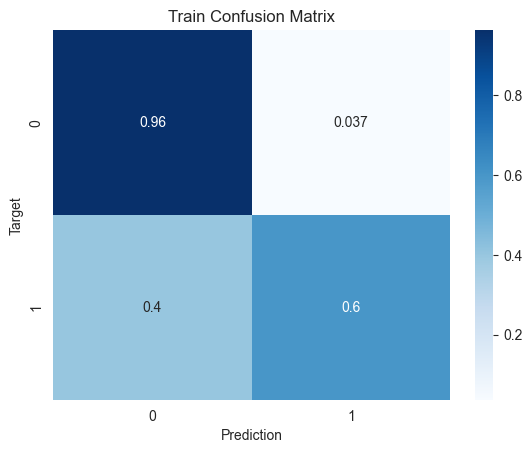

Area under ROC score on Validation dataset: 87.61%


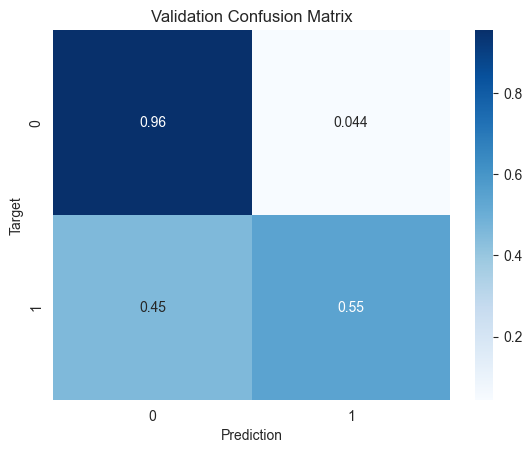

['saved_data/model_pipeline.joblib']

In [20]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)

RANDOM_STATE = 42

_train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=RANDOM_STATE, stratify=raw_df['Exited'])
train_df, val_df = train_test_split(_train_val_df, test_size=0.25, random_state=RANDOM_STATE, stratify=_train_val_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = train_df.columns[1:-1]  # to drop 'id' and 'Exited' columns
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Just as an idea
binary_cols = ['IsActiveMember', 'HasCrCard']  # not yet used, but can be for improvement
numeric_cols = train_inputs.drop(columns=binary_cols).select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.drop(columns=binary_cols).select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs) * 100
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'saved_data/model_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 94.51%


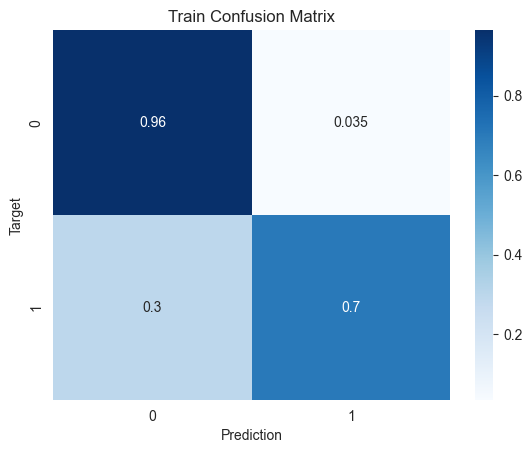

Area under ROC score on Validation dataset: 92.64%


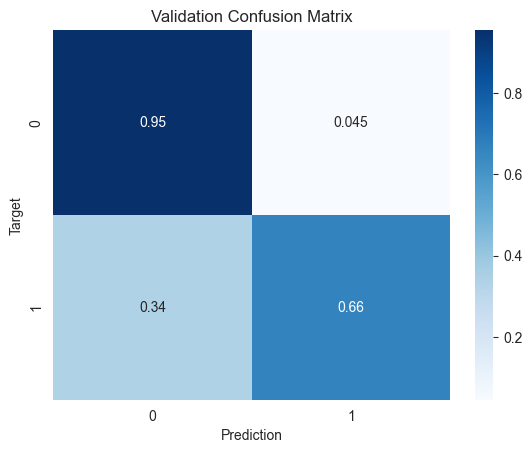

In [21]:
poly_features = PolynomialFeatures(degree=2)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', poly_features)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

**Висновок**:
Бачимо, що різниця у 2% між тренувальними та валідаційними даними. Тобто модель не має перенавчання, щоб показувати на валідаційних даних гірші результати. Модель добре генералізує. В цілому TN та TP покращились з поліноміальними ознаками. Модель добре генералізує.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 96.08%


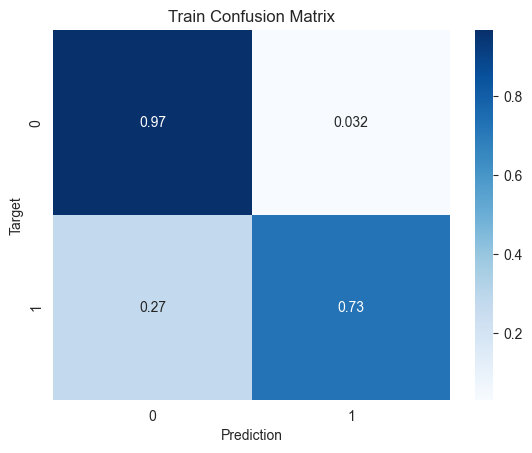

Area under ROC score on Validation dataset: 91.58%


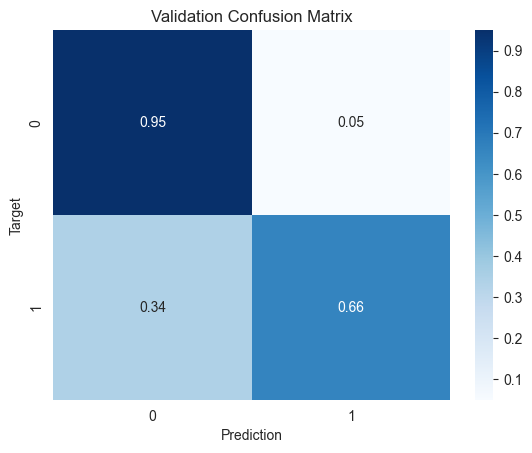

In [25]:
poly_features = PolynomialFeatures(degree=4)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', poly_features)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')
# Fill 'Exited' column with predictions from model_pipeline
sample_submission['Exited'] = model_pipeline.predict_proba(test_raw_df.drop(columns=['id']))[:, 1]

# Save the submission
sample_submission.to_csv('saved_data/submission_log_reg_poly_features_pipelines.csv', index=False)

**Висновок**:
Модель із третього завдання як на мене має краще результат. Чому?
Бо ця модель має на тренульваних даних 96.08%, коли на валідаційних 91.58%. Тобто в порівнянні із третього завдання (тренувальні - 94.51%, валідаційні - 92.64%). Ми бачимо, що на тренувальних дані покращились, але на валідаційниї покращились. Тобто пішов невеличкий variance.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [51]:
regression_df = pd.read_csv('regression_data.csv')

# print mean and std
print(regression_df.describe())

regression_train, regression_test = train_test_split(regression_df, test_size=0.2, random_state=RANDOM_STATE)

regression_X_train = regression_train
regression_y_train = regression_train['target']

regression_X_test = regression_test
regression_y_test = regression_test['target']

poly_features = PolynomialFeatures(degree=5)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', poly_features)
])

preprocessor = ColumnTransformer(
    transformers=[
        # Since all data are numeric, we don't need to specify the columns
        ('num', numeric_transformer, regression_X_train.columns)
    ]
)

model = LinearRegression()

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

model_pipeline.fit(regression_X_train, regression_y_train)

# Передбачення
train_preds = model_pipeline.predict(regression_X_train)
test_preds = model_pipeline.predict(regression_X_test)

def calculate_metrics(targets, preds):
    r2 = r2_score(targets, preds)
    rmse = root_mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)

    print(f"R2: {r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

print("Train metrics:")
calculate_metrics(regression_y_train, train_preds)

print("\nTest metrics:")
calculate_metrics(regression_y_test, test_preds)

        feature_1   feature_2   feature_3   feature_4   feature_5      target
count  129.000000  129.000000  129.000000  129.000000  129.000000  129.000000
mean    -0.082039   -0.017872    0.092293   -0.076084    0.053098   -3.902984
std      0.941214    1.065887    0.978557    0.910588    1.004498   45.466621
min     -3.241267   -2.619745   -1.913280   -2.211135   -2.301921 -111.753810
25%     -0.699726   -0.756351   -0.553649   -0.730367   -0.772825  -37.339533
50%     -0.066080   -0.161286    0.120296    0.018418    0.013002   -0.641298
75%      0.529804    0.679598    0.624120    0.519347    0.787085   25.464414
max      2.122156    3.852731    3.078881    2.314659    2.075401  115.125907
Train metrics:
R2: 1.00
RMSE: 0.00
MAE: 0.00

Test metrics:
R2: 0.74
RMSE: 24.46
MAE: 16.42


In [53]:
np.mean(regression_y_train), np.std(regression_y_train), np.min(regression_y_train)

(np.float64(-6.450753928428644),
 np.float64(44.13422004765027),
 np.float64(-111.75381023526477))

**Висновок**:
Модель перенавчена, бо ми бачимо, що на тренувальних даних RMSE 0 та r2 рівно 1 (в реальних умовах такого не зустріти, бо ML моделі стараються наблизитись до ідеального, але ніколи не будуть ідеальним) і в той час на тестових даних RMSE 24.46, а r2 0.74. Тобто модель перенавчена і не генералізована. Видимо, що поліном 5ої степені дуже сильно вплинув на модель.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [ ]:
models = [
    Lasso(),
    Ridge(),
    ElasticNet(),
]

for model in models: